# Description

This notebook is used to explore the FourCastNet inference results by visualizing and plotting interactively. The different visualizations include: 
* Time series -- for each prediction variable under one ablation
* Averaged metric -- per ablated variable
* Heatmap -- captures most of the results of the experiments in a single visual
    * Precipitation results and baseline results can be toggled on and off as part of the heatmap
* Channel maps -- displays predicted channel, ground truth, and their difference for multiple timesteps 
* Scatterplots -- compares ground truth to prediction, colored as a function of latitude
* Time series -- per ablated variable for one prediction variable

# Setup

In [316]:
import s3fs
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import re
from ipywidgets import interact, fixed, FloatSlider, IntRangeSlider, HBox, Label
import ipywidgets as widgets
import os

s3 = s3fs.S3FileSystem()

In [317]:
# Dictionaries for line style, color and index of variables
line_style_dict = {'U10': '-', 'V10': '--', 'T2m': '-.', 'sp': ':', 'mslp': '-', 'U1000': '--', 'V1000': '-.', 'Z1000': ':', 'T850': '-', 'U850': '--', 'V850': '-.', 'Z850': ':', 'RH850': '-', 'T500': '--', 'U500': '-.', 'V500': ':', 'Z500': '-', 'RH500': '--', 'Z50': '-.', 'TCWV': ':'}
line_color_dict = {'None': 'black', 'U10': 'b', 'V10': 'b', 'T2m': 'b', 'sp': 'b', 'mslp': 'g', 'U1000': 'g', 'V1000': 'g', 'Z1000': 'g', 'T850': 'r', 'U850': 'r', 'V850': 'r', 'Z850': 'r', 'RH850': 'c', 'T500': 'c', 'U500': 'c', 'V500': 'c', 'Z500': 'y', 'RH500': 'y', 'Z50': 'y', 'TCWV': 'y'}
index_dict = {'None': -1, 'U10': 0, 'V10': 1, 'T2m': 2, 'sp': 3, 'mslp': 4, 'U1000': 5, 'V1000': 6, 'Z1000': 7, 'T850': 8, 'U850': 9, 'V850': 10, 'Z850': 11, 'RH850': 12, 'T500': 13, 'U500': 14, 'V500': 15, 'Z500': 16, 'RH500': 17, 'Z50': 18, 'TCWV': 19}
name_dict = {-1: "None", 0: "U10", 1: "V10", 2: "T2m", 3: "sp", 4: "mslp", 5: "U1000", 6: "V1000", 7: "Z1000", 8: "T850", 9: "U850", 10: "V850", 11: "Z850", 12: "RH850", 13: "T500", 14: "U500", 15: "V500", 16: "Z500", 17: "RH500", 18: "Z50", 19: "TCWV"}

# Lists for prediction and ablation variables
predict_variables = ['U10', 'V10', 'T2m', 'sp', 'mslp', 'Z1000', 'Z850', 'RH850']
all_variables = ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV']

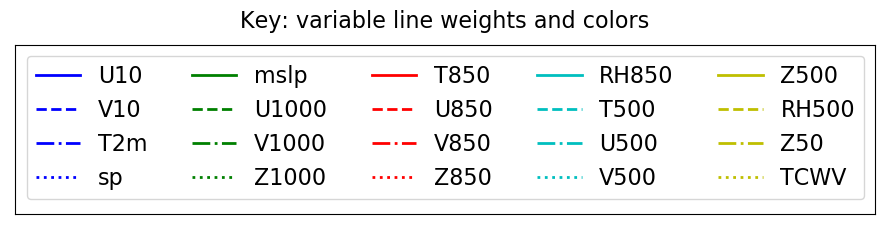

In [318]:
plt.figure(figsize=(11.1, 2.2))

for i, (label, line_style) in enumerate(line_style_dict.items()):
    plt.plot([0], [i], linestyle=line_style, color=line_color_dict[label], label=label, linewidth=2)

plt.title('Key: variable line weights and colors', fontsize=16, y=1.05)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=5, prop={'size': 16})
plt.xticks([])
plt.yticks([])
plt.show()

# Explore results

## Print data types

In [320]:
path = '../override_dir/baselines/predict-T2m_baseline_30-timesteps_vis.h5'
f = h5py.File(path, 'r')
print(f'File of type {type(f)}')
for key, val in f.items():
    print(f"Key '{key}' has value of type {type(f[key])}, shape: {f[key].shape}")
f.close()

File of type <class 'h5py._hl.files.File'>
Key 'acc' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'acc_coarse' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'acc_coarse_unweighted' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'acc_unweighted' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'ground_truth' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20, 720, 1440)
Key 'predicted' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20, 720, 1440)
Key 'rmse' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'rmse_coarse' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)


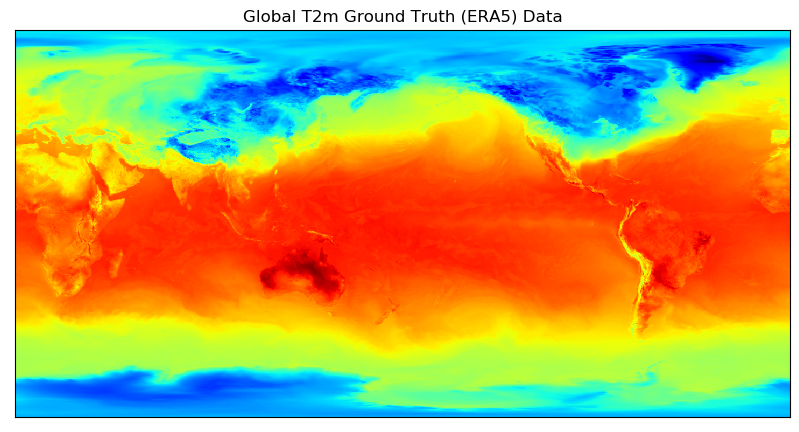

In [321]:
path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
f = h5py.File(path, 'r')

truth = f['ground_truth']
t = truth[0, 0, 2, :, :]

plt.figure(figsize=(10, 6))
# t[360:370, :] = np.zeros_like(t[360:370, :])
plt.imshow(t, cmap='jet', label=False)

# Remove tick labels on both x and y axes
plt.xticks([])
plt.yticks([])
plt.title("Global T2m Ground Truth (ERA5) Data")

plt.show()

f.close()

## Interactive visual display

### Widget code

In [335]:
slider_widget = widgets.IntRangeSlider(
    value=[0, 30],
    min=0,
    max=30,
    step=1,
    description='Timesteps:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

interval_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=14,
    step=1,
    description='Interval (b/w leadtimes):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    display='flex',
    style= {'description_width': 'initial'}
)


interval_widget = widgets.Dropdown(
    options=[('One timestep (every 6 hours / 0.25 days)', 1), ('Two timesteps (every 12 hours / 0.5 days)', 2),
             ('Four timesteps (every 24 hours / 1 day)', 4), ('Eight timesteps (every 48 hours / 2 days)', 8)],
    value=4,
    description='Interval:',
    style = {'description_width': 'initial'}
)

predict_widget = widgets.SelectMultiple(
    options=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    rows=len(all_variables),
    description='Predict Vars:',
    disabled=False,
)

ablate_widget = widgets.SelectMultiple(
    options=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    rows=len(all_variables),
    description='Ablated Vars:',
    disabled=False,
)

select_widget = widgets.Select(
    options=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value='U10', 
    # rows=len(all_variables),
    description='Channel to map:',
    disabled=False,
    style= {'description_width': 'initial'}
)

select_ablate_widget = widgets.Select(
    options=['Baseline (no ablation)', 'U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value='Baseline (no ablation)', 
    # rows=len(all_variables + 1),
    description='Ablated variable:',
    disabled=False,
    style= {'description_width': 'initial'}
)

select_ablate_widget_2 = widgets.Select(
    options=['Baseline (no ablation)', 'U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value='Baseline (no ablation)', 
    # rows=len(all_variables + 1),
    description='Ablated variable:',
    disabled=False,
    style= {'description_width': 'initial'}
)

metric_widget = widgets.ToggleButtons(
    options=['ACC', 'RMSE', 'Both'],
    description='Metric:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Anomaly Correlation Coefficient (measure of predictive skill)', 'Root Mean Squared Error'],
)

checkbox_widget = widgets.Checkbox(
    value=True,
    description='Display numerical labels',
    disabled=False,
    indent=False
)

log_widget = widgets.Checkbox(
    value=False,
    description='Display log() of metric',
    disabled=False,
    indent=False
)

baseline_widget = widgets.Checkbox(
    value=True,
    description='Display baseline inference data (no ablation)',
    disabled=False,
    indent=False
)


precip_widget = widgets.Checkbox(
    value=True,
    description='Display precipitation as additional predict variable)',
    disabled=False,
    indent=False
)

difference_widget = widgets.Checkbox(
    value=True,
    description='Display "difference" between prediction & truth',
    disabled=False,
    indent=False
)


### For scatterplot 
scatter_select_ablate_widget = widgets.Select(
    options=['Baseline (no ablation)', 'U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value='Baseline (no ablation)', 
    # rows=len(all_variables + 1),
    description='Ablated variable:',
    disabled=False,
    style= {'description_width': 'initial'}
)

scatter_select_widget = widgets.Select(
    options=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value='U10', 
    # rows=len(all_variables),
    description='Prediction variable:',
    disabled=False,
    style= {'description_width': 'initial'}
)

scatter_timestep_widget = widgets.IntSlider(
    value=0,
    min=0,
    max=30,
    step=1,
    description='Timestep:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    display='flex',
    style= {'description_width': 'initial'}
)


### Metric mean by variable code

In [323]:
def compare_metric_togglable(variables, ablate_var, step_range, metric, path, value_label):
    if not variables:
        print("No variables selected.")
        return

    # Open file and extract data
    f = h5py.File(path, 'r')
    metric = metric.lower()
    arr = f[metric]
    
    # Adjust start/end steps according to file size
    start, stop = step_range
    max_steps = arr.shape[1]
    end_step = stop if stop <= max_steps else max_steps

    # Isolate the variables and timesteps of interest then find the mean for each variable
    indices = [index_dict[var] for var in variables]
    values = np.mean(arr[0,start:end_step,indices], axis=0)  # 0-index to remove extra dimension

    # Normalize the values to the range [0, 1] so colors display properly
    norm = mcolors.Normalize(vmin=0, vmax=max(values))
    normalized_values = norm(values)
    
    # Create a bar graph
    fig, ax = plt.subplots(figsize=(10, 6))
    y_upper = 1.2*max(values) + 8 if metric == 'rmse' else 1.1
    y_lower = 0 if min(values) > 0 else -1  # negative only if necessary
    ax.set_ylim(y_lower, y_upper)
    
    # Create a ScalarMappable object to set the color bar
    if metric=='acc':
        bars = ax.bar(variables, values, color=plt.cm.viridis(normalized_values))
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    elif metric=='rmse':
        bars = ax.bar(variables, values, color=plt.cm.YlOrRd(normalized_values))
        sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
    cbar = plt.colorbar(sm)

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation='vertical')
    
    # Label figure and axes appropriately
    plt.ylabel(f'{metric.upper()}', fontsize=14, labelpad=15)
    plt.xlabel('Variables', fontsize=14, labelpad=15)
    plt.title(f'{metric.upper()} by Variable Averaged Over Timesteps {start}-{end_step} ({ablate_var} Ablated)', fontsize=20, y=1.02)
    
    if value_label:  # Display numerical labels over each bar if desired
        for bar, value in zip(bars, values):
            # define text location/rotation based on space availability
            text_x = bar.get_x() + bar.get_width() / 2
            text_y = bar.get_height() + y_upper*0.02 if bar.get_height() > 0 else y_upper*0.02
            text_val = f"{value:.3g}"
            text_rot = 0 if len(text_val) <= 6 else 90
            plt.text(text_x, text_y, text_val, ha='center', va='bottom', rotation=text_rot, fontsize=8)
    
    # Show graph and close data file to free up memory
    plt.tight_layout()
    plt.show()
    f.close()

### Time series code

In [324]:
def timeseries_togglable(variables, ablate_var, step_range, metric, path):
    f = h5py.File(path, 'r')
    metric = metric.lower()
    steps = f[metric].shape[1]
    start, stop = step_range       
    
    plt.figure(figsize=(10, 6))
    for var in variables:
        index, style, color = index_dict[var], line_style_dict[var], line_color_dict[var]
        plt.plot(np.arange(steps), f[metric][0, :, index_dict[var]], linestyle=style, color=color, label=var)
        
    plt.axvline(x=start, color='grey', linestyle='-', linewidth=2, alpha=0.5, label="Start")
    plt.axvline(x=stop, color='grey', linestyle='-', linewidth=2, alpha=0.8, label="Stop")
    plt.axvspan(0, start, facecolor='grey', alpha=0.2)
    plt.axvspan(stop, steps, facecolor='grey', alpha=0.2)
    
    plt.xlabel('Timesteps', fontsize=14, labelpad=15)
    plt.ylabel(f'{metric.upper()}', fontsize=14, labelpad=15)
    plt.title(f'{metric.upper()} Over {steps} Timesteps ({ablate_var} Ablated)', fontsize=20, y=1.02)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    f.close()

### Heatmap code

In [325]:
def heatmap_togglable(predict_vars, ablate_vars, step_range, metric, directory_path, log, baseline, precip):
    """Show the relative impact of variable ablations on variable prediction.
    
    Parameters:
    -----------
    predict_vars : list of str
        The variables being predicted (y-axis).
    ablate_vars : list of str
        The variables being ablated (x-axis).
    step_range : list of int or tuple of int
        The timesteps over which the evaluation metric will be averaged (default to all).
    metric : str
        Evaluation metric to be displayed ('ACC', 'RMSE', or 'Both'). Expects capitalization, function converts to lower().
    path : str
        Relative path to the data.
    log : boolean
        Determines whether or not the log of the values should be displayed.
    baseline : boolean
        Determines whether or not data from the baseline inference (no ablation) should be displayed.
    """
    paths = {}
    for file in os.listdir(directory_path):
        for var in ablate_vars:
            if f'-{var}_' in file:
                file_path = os.path.join(directory_path, file)
                paths[index_dict[var]] = file_path  # store using variable index to maintain proper order
    paths = sorted(paths.items())
    
    start, stop = step_range
    
    ablate_idxs = [index_dict[var] for var in ablate_vars]
    predict_idxs = [index_dict[var] for var in predict_vars]
    
    metric_list = []
 
    for i, path in paths:
        f = h5py.File(path, 'r')
        m = f[metric.lower()][0,start:stop,predict_idxs] # take timestep range for all prediction variables
        m = np.mean(m, axis=0) if len(m.shape) > 1 else m
        if name_dict[i] in predict_vars:
            m[predict_idxs.index(i)] = 0  # zero out the predict value for the variable being ablated
        m = m[::-1] # reverse order so (0,0) appears on the lower left corner
        metric_list.append(m)
        f.close()
    
    # Append the baseline results here
    if baseline:
        # Add baseline to label 
        ablate_vars = list(ablate_vars)
        ablate_vars.append('Baseline')
        # Extract data
        baseline_path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
        f_base = h5py.File(baseline_path, 'r')
        bl = f_base[metric.lower()][0,start:stop,predict_idxs]
        bl = np.mean(bl, axis=0) if len(bl.shape) > 1 else bl  # take the mean over time range
        bl = bl[::-1]  # reverse order so displays properly
        metric_list.append(bl)
        f_base.close()
    
    # Transpose data so (0,0) appears on the lower left corner
    data = np.vstack(metric_list).T
    
    # Append precipitation results here
    if precip:
        predict_vars = list(predict_vars)
        predict_vars.append('Precipitation')
        precip_idx = 0
        precip_row = []
        directory_path = '../override_dir/precip/results'
        for var in ablate_vars:
            if var is not 'Baseline':
                path = directory_path + f'/tp_ablate-{var}_30-timesteps.h5'
                f_precip = h5py.File(path, 'r')
                p = f_precip[metric.lower()][0, start:stop, precip_idx] # get metric for precip over time range
                p = np.mean(p, axis=0)  # take mean over time range
                precip_row.append(p)
        if baseline:
            baseline_path = '../override_dir/precip/tp_baseline_30-timesteps.h5'
            f_base = h5py.File(baseline_path, 'r')
            p = f_base[metric.lower()][0, start:stop, precip_idx] # get metric for precip over time range
            p = np.mean(p, axis=0)  # take mean over time range
            precip_row.append(p)
        precip_row = np.array(precip_row) # convert to np array before stacking onto the data
        data = np.insert(data, 0, precip_row, axis=0)
        
    # Take log of data if desired
    data = np.log(data) if log else data
    
    fig = plt.figure()
    
    # Choose color scheme so high ACC corresponds to low RMSE
    if metric.lower() == 'rmse':
        color = 'inferno_r'
        heatmap = plt.imshow(data, cmap=color, interpolation='nearest') 
    elif metric.lower() == 'acc':
        color = 'bwr'
        heatmap = plt.imshow(data, cmap=color, interpolation='nearest', vmin=-1, vmax=1) 

    # Set categorical labels for x-axis and y-axis
    plt.xticks(np.arange(len(ablate_vars)), ablate_vars, rotation=90)
    plt.yticks(np.arange(len(predict_vars)), reversed(predict_vars))

    plt.colorbar(heatmap, fraction=0.046, pad=0.048)  # "magic" values to keep the bar to scale with the plot
    plt.xlabel('Ablated Variables', labelpad=10, fontsize=14)
    plt.ylabel('Prediction Variables', labelpad=-10, fontsize=14)
    
    label = f'log({metric.upper()})' if log else metric.upper()
    x_mid = (fig.subplotpars.right + fig.subplotpars.left)/2
    
    # plt.suptitle(f'Effects of ablated variables on {label} of predict variables', ha='center', fontsize=16)
    # plt.title(f'Mean across timesteps {start}-{stop}', fontsize=12)
    fig.text(x_mid, 1, f"Impacts of Ablations on Predictive Skill", ha='center', fontsize=20)
    fig.text(x_mid, 0.92, f'{label} averaged across timesteps {start}-{stop}', ha='center', fontsize=16)

    plt.show()
    

### Channel map code

In [326]:
def channel_map_togglable(select_var, ablate_var, interval, directory_path, difference):
    """Map a channel prediction vs ERA5 ground truth over several timesteps.
    
    Parameters:
    -----------
    select_var : str
        The variable to be displayed.
    interval : int
        Adjusts the interval between consecutive maps (1 => every 6 hours, 4 => every day).
    directory_path : str
        Relative path to the data.
    difference : boolean
        Determines whether or not to display the maps showing the difference between prediction and ground truth.
    """
    file_path = None
    
    # Retrieve baseline data or iterate through directory for correct ablation data
    if ablate_var == 'Baseline (no ablation)':
        file_path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
        ablate_var = 'Nothing'  # reset for use in figure title 
    else:
        for file in os.listdir(directory_path):
            if f'-{ablate_var}_' in file:
                file_path = os.path.join(directory_path, file)
                break
                
    # Open file and extract data
    f = h5py.File(file_path, 'r')
    pred = f['predicted']
    truth = f['ground_truth']
    
    # Determine the number of steps, and use the interval size to determine number of maps
    max_maps = 8
    steps = pred.shape[1]
    n_maps = int(steps / interval) + 1
    n_maps = int(max_maps) if max_maps < n_maps else int(n_maps)  # cap number at the max 
    
    # Set up plot dimensions
    columns = ['Prediction', 'Ground Truth']
    fig_size = (15, 4 * n_maps)
    if difference:
        columns.append('Difference')
        fig_size = (15, 2.7 * n_maps)
    
    fig, axes = plt.subplots(n_maps, len(columns), figsize=fig_size)
    fig.subplots_adjust(hspace=0)
    # fig.subplots_adjust(hspace=0.1, wspace=0.12) # adjust as needed
    
    # Get the channel index
    c = index_dict[select_var]
    bar_shrink_ratio = 0.75
    
    
    all_pred_data = pred[0,:n_maps*interval, c, :, :]
    all_truth_data = truth[0,:n_maps*interval, c, :, :]
    # Find the maximum absolute value in both prediction and ground truth arrays
    max_value = max(np.max(np.abs(all_pred_data)), np.max(np.abs(all_truth_data)))
    max_truth, min_truth = np.max(all_truth_data), np.min(all_truth_data)
    max_pred, min_pred  = np.max(all_pred_data), np.min(all_pred_data)
    max_diff = np.max(np.abs(np.subtract(all_pred_data, all_truth_data)))

    for i in range(n_maps):
        t = i*interval
        
        # Plot the predictions
        var_data_pred = pred[0, t, c, :, :]
        ax = axes[i, 0]
        im = ax.imshow(var_data_pred, cmap='jet', vmin=min_truth, vmax=max_truth)  # Modify the cmap if desired
        ax.set_title(f'Predicted: {t*6}-hour ({t*6/24}-day) leadtime')
        cbar1 = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04, shrink=bar_shrink_ratio)
        cbar1.ax.yaxis.set_tick_params(width=0.5)  # Adjust the width of colorbar ticks
        # Remove tick marks on both x and y axes
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Plot the ground truth
        var_data_truth = truth[0, t, c, :, :]
        ax = axes[i, 1]
        im = ax.imshow(var_data_truth, cmap='jet', vmin=min_truth, vmax=max_truth)  # Modify the cmap if desired
        ax.set_title(f'Ground Truth: {t*6}-hour ({t*6/24}-day) leadtime')
        cbar2 = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04, shrink=bar_shrink_ratio)
        cbar2.ax.yaxis.set_tick_params(width=0.5)  # Adjust the width of colorbar ticks
        # Remove tick marks on both x and y axes
        ax.set_xticks([])
        ax.set_yticks([])
        
        if difference:
            var_data_diff = np.subtract(var_data_pred, var_data_truth)
            # max_diff = np.max(var_data_diff)
            # Plot the variable
            ax = axes[i, 2]
            im = ax.imshow(var_data_diff, cmap='bwr', vmin=-max_diff, vmax=max_diff)  # Modify the cmap if desired
            ax.set_title(f'Difference: {t*6}-hour ({t*6/24}-day) leadtime')
            cbar3 = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04, shrink=bar_shrink_ratio)
            cbar3.ax.yaxis.set_tick_params(width=0.5)  # Adjust the width of colorbar ticks
            # Remove tick marks on both x and y axes
            ax.set_xticks([])
            ax.set_yticks([])
    
    
    # Show the plot
    plt.suptitle(f"{select_var}: Predicted vs. Ground Truth with {ablate_var} Ablated", fontsize=20, y=.9)
    plt.show()
    f.close()

### Scatterplot code

In [327]:
def scatterplot_togglable(select_var, ablate_var, timestep, directory_path):
    """Compare prediction to ground truth for all global locations
    
    Parameters
    ----------
    select_var: str
        The variable being predicted
    ablate_var: str
        The variable that was ablated during inference (default to Baseline (No ablation))
    step_range: list of int
        The range of timesteps over which the values are averaged.
    directory_path: str
        The directory that holds inference experiment results
    """
    file_path = None
    
    # Retrieve baseline data or iterate through directory for correct ablation data
    if ablate_var == 'Baseline (no ablation)':
        file_path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
        ablate_var = 'Nothing'  # reset for use in figure title 
    else:
        for file in os.listdir(directory_path):
            if f'-{ablate_var}_' in file:
                file_path = os.path.join(directory_path, file)
                break        
    # Open file and extract data
    f = h5py.File(file_path, 'r')
    pred = f['predicted']
    truth = f['ground_truth']
    
    predict_index = index_dict[select_var]
    x = pred[0, timestep, predict_index, :, :]
    y = truth[0, timestep, predict_index, :, :]
    # Create a 720 by 1440 array with row numbers
    rows = 720
    array = np.zeros(rows)
    middle_row = rows // 2 - 1

    for row in range(rows):
        array[row] = (row - middle_row)//4
    
    array = array[::-1]  # reverse array so 90 is at the top of the image and -90 is at bottom
    array = array.reshape(720, 1)

    # Repeat the array horizontally to create a 720 by 1440 array
    latitude_values = np.tile(array, (1, 1440))
    cm = 'brg'

    # Create scatterplot where the x value is the mean 
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figsize values as needed
    plt.scatter(x, y, c=latitude_values, cmap=cm, s=2)
    # plt.scatter([1,2], [1, 2])
    
    # subtitle
    subtitle_text = f'{timestep*6}-hour ({timestep*6/24}-day) leadtime'
    fig.text(0.12, 0.9, subtitle_text, ha='left', fontsize=16, color='#333333')
    
    # acc display 
    acc = f['acc'][0, timestep, predict_index]
    acc_rounded = str(np.round(acc, 3))
    print(acc_rounded)
    metric_text = f'ACC = {acc_rounded}'
    fig.text(.75, 0.9, metric_text, ha='right', fontsize=16, color='#333333')
    
    # Plot line of 
    truth_min, truth_max = np.min(y), np.max(y)
    plt.plot([truth_min, truth_max], [truth_min, truth_max], color='gray', linestyle='--', linewidth=1, label='x=y Line')

    # title/axis labels
    plt.title(f'{select_var} Predicted vs. Ground Truth with {ablate_var} Ablated', fontsize=20, y=1.1)
    plt.ylabel(f'Ground truth values of {select_var}', fontsize=14)
    plt.xlabel(f'Predicted values of {select_var}', fontsize=14)
    # norm = plt.Normalize(vmin=-90, vmax=90)
    bounds = [-90, -60, -30, 0, 30, 60, 90]
    cbar = plt.colorbar(label='Latitude', ticks=bounds)
    cbar.ax.set_ylabel('Latitude', fontsize=14, rotation='vertical', va='top')
    cbar.ax.set_yticklabels([-90, -60, -30, 0, 30, 60, 90])
    
    plt.show()
    f.close()

-0.22


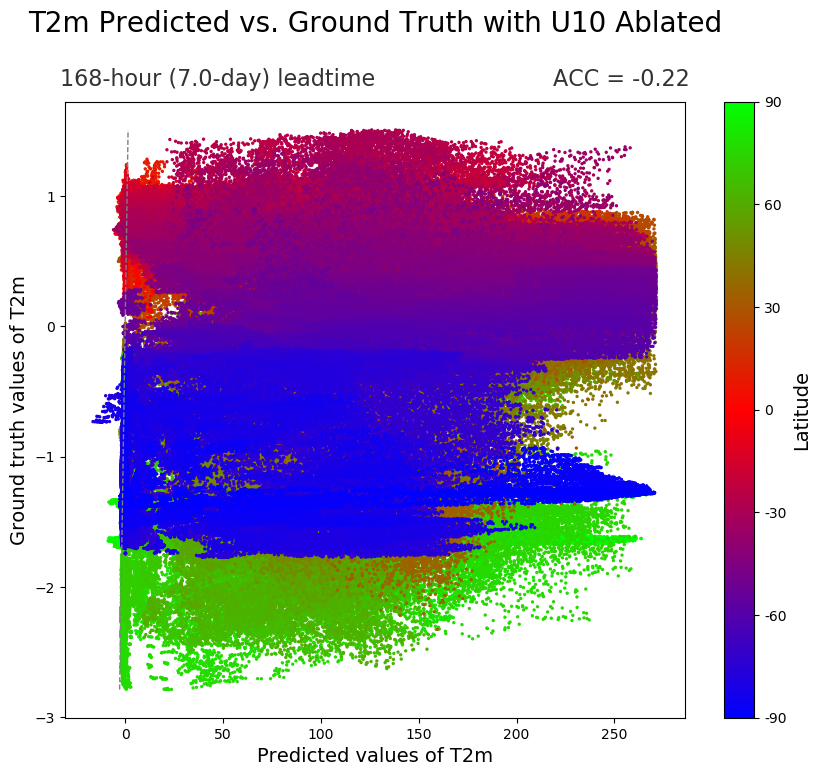

In [342]:
select_var = 'T2m'
ablate_var = 'U10'  # 'Baseline (no ablation)'
timestep = 28
directory_path = '../override_dir/iterative_ablation/results'

scatterplot_togglable(select_var, ablate_var, timestep, directory_path)

### Time series by ablation code

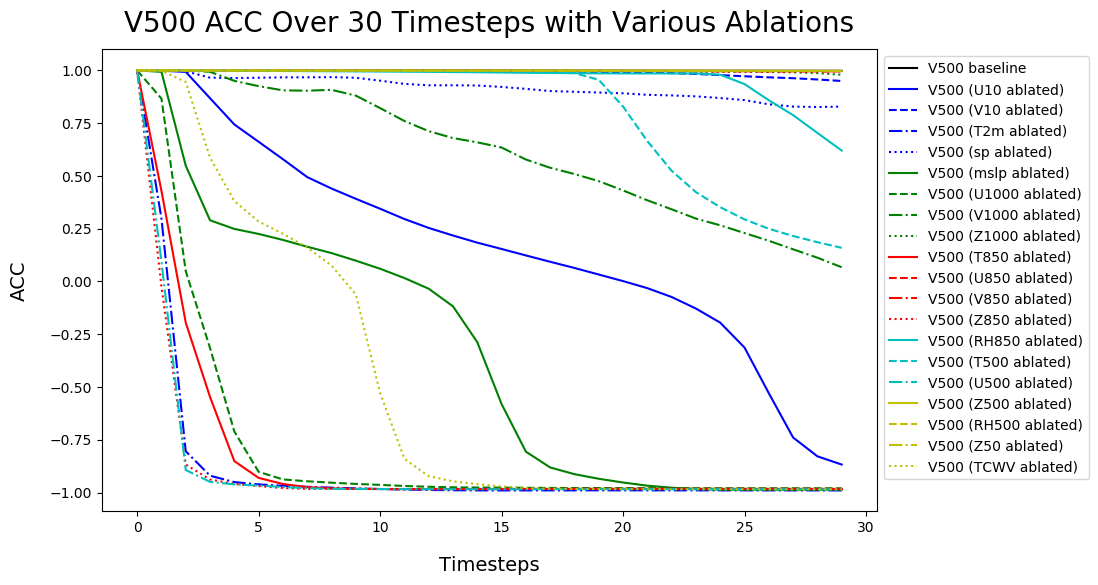

In [110]:
def timeseries_by_ablated(predict_var, ablate_vars, step_range, metric, directory_path):
    metric = metric.lower()
    start, stop = step_range
    steps = stop-start
    predict_idx = index_dict[predict_var]
    
    plt.figure(figsize=(10, 6))
    
    # Start with Baseline (no ablation)
    file_path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
    f = h5py.File(file_path, 'r')

    style, color = '-', 'black'
    label = f'{predict_var} baseline'
    plt.plot(np.arange(start, stop), f[metric][0, :, predict_idx], linestyle=style, color=color, label=label)
    f.close()
    
    # Then do the other ablations
    for var in ablate_vars:
        if var != predict_var:  # don't plot predict variable if it is ablated
            file_path = directory_path + f'/iter_ablate-{var}_30-timesteps_vis.h5'
            f = h5py.File(file_path, 'r')
            style, color = line_style_dict[var], line_color_dict[var]
            label = f'{predict_var} ({var} ablated)'
            plt.plot(np.arange(start, stop), f[metric][0, :, predict_idx], linestyle=style, color=color, label=label)
            f.close()            
        
    plt.xlabel('Timesteps', fontsize=14, labelpad=15)
    plt.ylabel(f'{metric.upper()}', fontsize=14, labelpad=15)
    plt.title(f'{predict_var} {metric.upper()} Over {steps} Timesteps with Various Ablations', fontsize=20, y=1.02)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    

# Time series by ablated variable for one prediction variable
predict_var = 'V500'
ablate_vars = all_variables
step_range = [0, 30]
metric = 'ACC'
directory_path = '../override_dir/iterative_ablation/results'

timeseries_by_ablated(predict_var, ablate_vars, step_range, metric, directory_path)

### Interactive display: Scatterplots

In [36]:
# Widget for scatterplot
@interact(select_var=scatter_select_widget, ablate_var=scatter_select_ablate_widget, timestep=scatter_timestep_widget)

def toggle_scatterplot(select_var, ablate_var, timestep):
    directory_path = '../override_dir/iterative_ablation/results'
    scatterplot_togglable(select_var, ablate_var, timestep, directory_path)

interactive(children=(Select(description='Prediction variable:', index=2, options=('U10', 'V10', 'T2m', 'sp', …

### Interactive display: Channel Maps

In [336]:
# Widget for channel maps
@interact(select_var=select_widget, ablate_var=select_ablate_widget, interval=interval_widget, difference=difference_widget)

def toggle_channel_map(select_var, ablate_var, interval, difference):
    directory_path = '../override_dir/iterative_ablation/results'
    channel_map_togglable(select_var, ablate_var, interval, directory_path, difference)
    

interactive(children=(Select(description='Channel to map:', options=('U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000…

### Interactive display: Heatmaps

In [83]:
# Widget for heatmap (visualize all ablation experiments at once)
@interact(metric=metric_widget, log=log_widget, step_range=slider_widget, predict_vars=predict_widget, ablate_vars=ablate_widget, baseline=baseline_widget, precip=precip_widget)

def toggle_heatmap(metric, log, baseline, precip, step_range, predict_vars, ablate_vars):
    path = '../override_dir/iterative_ablation/results'
    
    if metric == 'Both':
        heatmap_togglable(predict_vars, ablate_vars, step_range, 'acc', path, log, baseline, precip)
        heatmap_togglable(predict_vars, ablate_vars, step_range, 'rmse', path, log, baseline, precip)
    else:
        heatmap_togglable(predict_vars, ablate_vars, step_range, metric, path, log, baseline, precip)

interactive(children=(ToggleButtons(description='Metric:', options=('ACC', 'RMSE', 'Both'), tooltips=('Anomaly…

### Interactive display: Time series and Metric by variable for a single ablation

In [21]:
# Using interact to create a widget for toggling metrics, step range, variables, and labels
@interact(metric=metric_widget, step_range=slider_widget, predict_vars=predict_widget, ablate_var=select_ablate_widget_2, value_label=checkbox_widget)

def toggle_widgets(metric, step_range, predict_vars, ablate_var, value_label):
    # path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
    # path = '../override_dir/ablation_experiments/mslp/predict-mslp_ablate-U10_30-timesteps_vis.h5'
    # path = '../override_dir/ablation_experiments/mslp/predict-mslp_ablate-V10_30-timesteps_vis.h5'
    # path = '../override_dir/iterative_ablation/predict-T2m_ablate-T2m_9-timesteps_vis.h5'
    # path = '../override_dir/iterative_ablation/predict-V10_ablate-V10_9-timesteps_vis.h5'
    if ablate_var == 'Baseline (no ablation)':
        path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
        ablate_var = 'Nothing'  # for figure titles
    else:
        path = f'../override_dir/iterative_ablation/results/iter_ablate-{ablate_var}_30-timesteps_vis.h5'

    if metric == 'Both':
        compare_metric_togglable(predict_vars, ablate_var, step_range, 'acc', path, value_label)
        timeseries_togglable(predict_vars, ablate_var, step_range, 'acc', path)
        compare_metric_togglable(predict_vars, ablate_var, step_range, 'rmse', path, value_label)
        timeseries_togglable(predict_vars, ablate_var, step_range, 'rmse', path)
    else:
        compare_metric_togglable(predict_vars, ablate_var, step_range, metric, path, value_label)
        timeseries_togglable(predict_vars, ablate_var, step_range, metric, path)


interactive(children=(ToggleButtons(description='Metric:', options=('ACC', 'RMSE', 'Both'), tooltips=('Anomaly…

# ------------------------------------------------------------------------

# Scratchwork

## Colormaps

In [ ]:
# define top and bottom colormaps 
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')


In [ ]:
from matplotlib import colors
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm

def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

cdict = {
    'red':((0.0,inter_from_256(64),inter_from_256(64)),
           (1/5*1,inter_from_256(112),inter_from_256(112)),
           (1/5*2,inter_from_256(230),inter_from_256(230)),
           (1/5*3,inter_from_256(253),inter_from_256(253)),
           (1/5*4,inter_from_256(244),inter_from_256(244)),
           (1.0,inter_from_256(169),inter_from_256(169))),
    'green': ((0.0, inter_from_256(57), inter_from_256(57)),
            (1 / 5 * 1, inter_from_256(198), inter_from_256(198)),
            (1 / 5 * 2, inter_from_256(241), inter_from_256(241)),
            (1 / 5 * 3, inter_from_256(219), inter_from_256(219)),
            (1 / 5 * 4, inter_from_256(109), inter_from_256(109)),
            (1.0, inter_from_256(23), inter_from_256(23))),
    'blue': ((0.0, inter_from_256(144), inter_from_256(144)),
              (1 / 5 * 1, inter_from_256(162), inter_from_256(162)),
              (1 / 5 * 2, inter_from_256(246), inter_from_256(146)),
              (1 / 5 * 3, inter_from_256(127), inter_from_256(127)),
              (1 / 5 * 4, inter_from_256(69), inter_from_256(69)),
              (1.0, inter_from_256(69), inter_from_256(69))),
}

new_cmap = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)


fig,ax = plt.subplots()
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap=new_cmap),ax=ax)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Define custom colormap
colors = ['#0000FF', '#FFA500', '#00FF00']  # Blue, Orange, Green
n_bins = 100  # Number of discrete color bins
cmap_name = 'custom_gradient'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Create example data
data = np.random.rand(10, 10) * 2 - 1

# Create a plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap=cm)

# Create a custom color bar
bounds = np.linspace(-1, 1, n_bins+1)
bounds = plt.Normalize(vmin=-1, vmax=1)
cbar = ColorbarBase(plt.gca(), cmap=cm, norm=norm, ticks=bounds, orientation='vertical')
cbar.set_label('Custom Color Bar')

plt.title('Custom Color Bar Example')
plt.show()


In [ ]:
data = np.random.rand(10, 10) * 90 - 1
data[0, 0] = -90
data[0, 1] = 90

# Sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.spring(np.linspace(0., 1, 128))
colors2 = plt.cm.autumn_r(np.linspace(0, 1, 128))

# Combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# Define the tickmarks
tick_marks = [-90, -60, -30, 0, 30, 60, 90]

plt.pcolor(data, cmap=mymap)
plt.colorbar(ticks=tick_marks)
plt.show()

## Plot Metric for each variable over timesteps

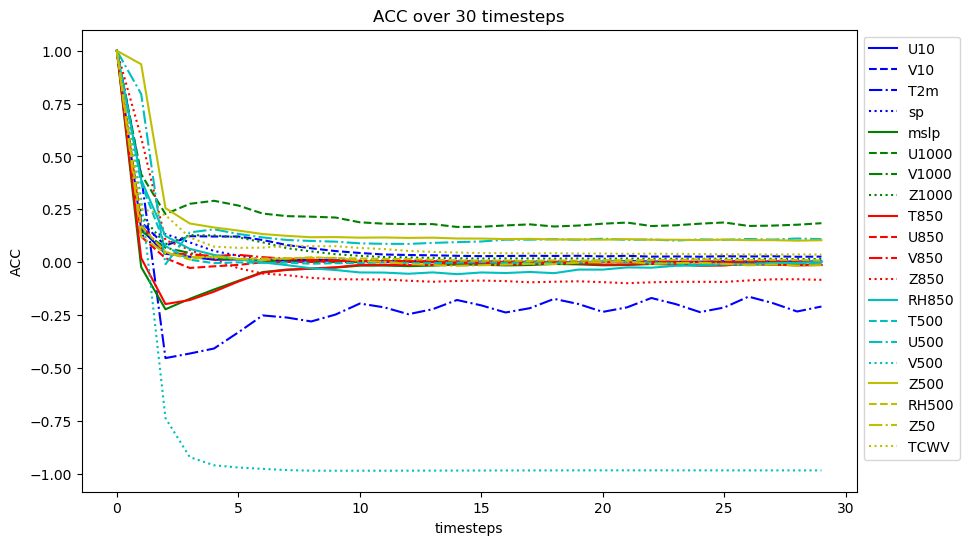

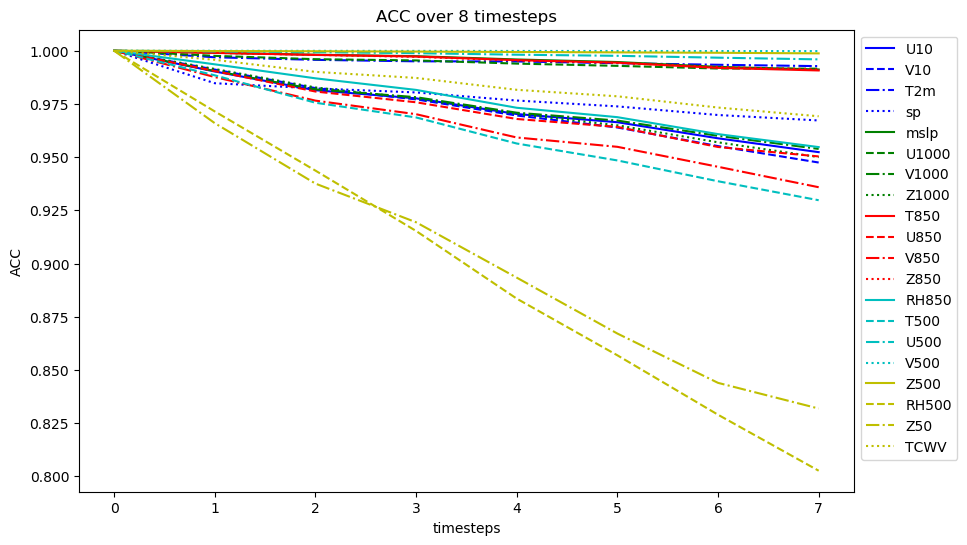

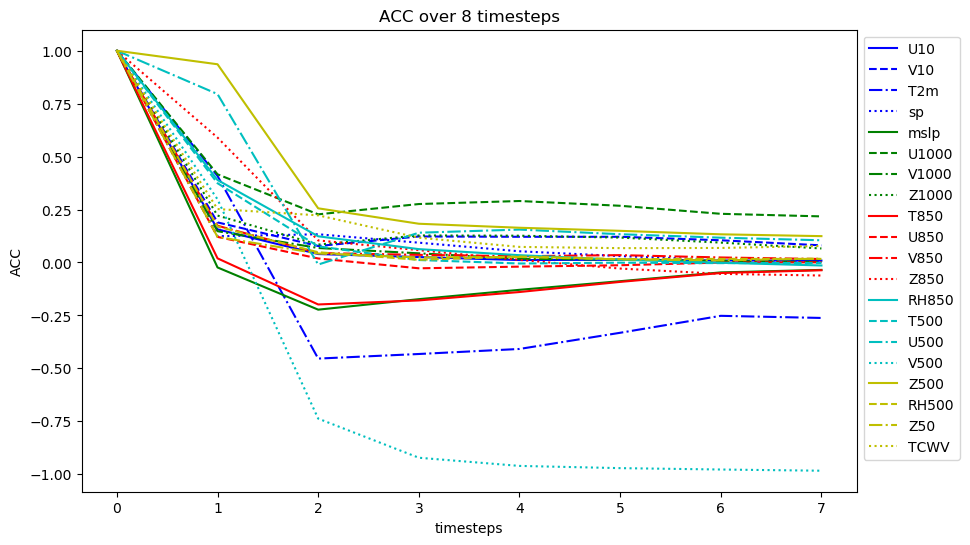

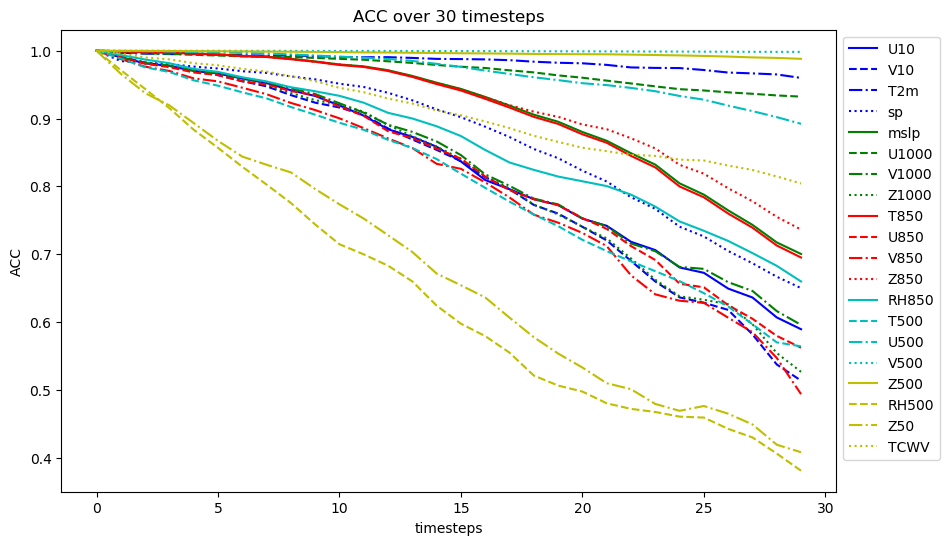

In [99]:
def plot_metric(file_path, metric, steps=30, variables=all_variables):
    f = h5py.File(file_path, 'r')
    
    # Adjust steps in case file has fewer
    if f[metric].shape[1] < steps:  
        steps = f[metric].shape[1]
    
    plt.figure(figsize=(10, 6))
    for var in variables:
        index, style, color = index_dict[var], line_style_dict[var], line_color_dict[var]
        plt.plot(np.arange(steps), f[metric][0, :steps, index_dict[var]], linestyle=style, color=color, label=var)
    plt.xlabel('timesteps')
    plt.ylabel(f'{metric.upper()}')
    plt.title(f'{metric.upper()} over {steps} timesteps')
    # plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    f.close()

# path = '../override_dir/iterative_ablation/predict-T2m_baseline_30-timesteps_vis.h5'
# plot_metric(path, 'acc', steps=30)

# path = '../override_dir/ablation_experiments/T2m/predict-T2m_ablate-mslp_30-timesteps_vis.h5'
# plot_metric(path, 'rmse')
# plot_metric(path, 'acc')

path = '../override_dir/ablation_experiments/U10/predict-U10_ablate-T2m_30-timesteps_vis.h5'
plot_metric(path, 'acc', steps)

path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis.h5'
plot_metric(path, 'acc', steps)

path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis_test1.h5'
plot_metric(path, 'acc', steps)

path = '../override_dir/baselines/predict-T2m_baseline_30-timesteps_vis.h5'
plot_metric(path, 'acc', steps)

## Compare Metric mean values for each variable

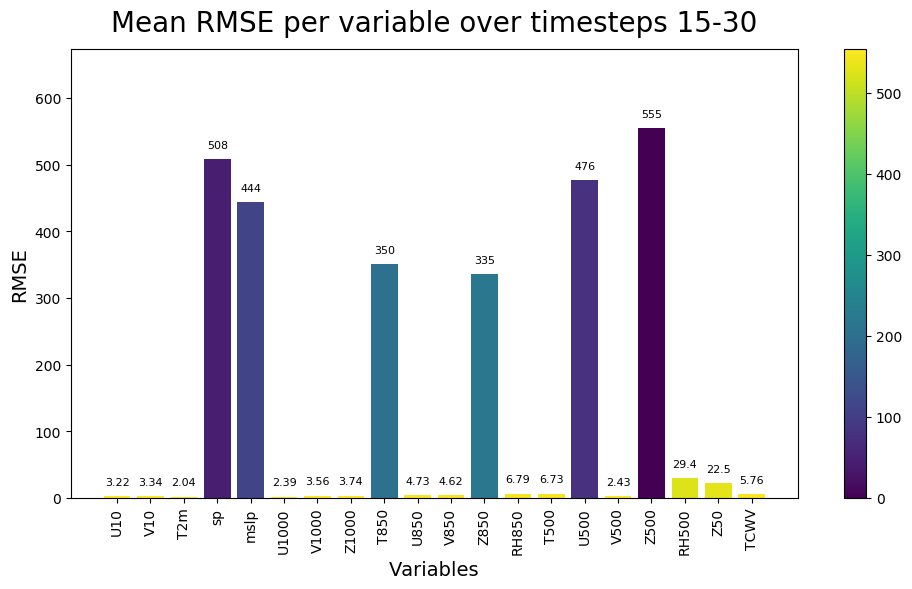

In [56]:
def compare_metric(variables, metric, steps, path, start=0, label=True):
    if not variables:
        print("No variables selected.")
        return
    
    f = h5py.File(path, 'r')
    arr = f[metric]
    
    # Adjust start/end steps according to file size
    max_steps = arr.shape[1]
    end_step = start+steps if start+steps <= max_steps else max_steps

    # Isolate the variables and timesteps of interest then find the mean for each variable
    indices = [index_dict[var] for var in variables]
    values = np.mean(arr[0,start:end_step,indices], axis=0)  # 0-index to remove extra dimension

    # Normalize the values to the range [0, 1]
    norm = mcolors.Normalize(vmin=0, vmax=max(values))
    normalized_values = norm(values) if metric is 'acc' else 1-norm(values)
    
    # Create a bar graph
    fig, ax = plt.subplots(figsize=(10, 6))
    # if metric is 'acc':
    y_upper = 1.2*max(values) + 8 if metric == 'rmse' else 1.2
    y_lower = 0
    ax.set_ylim(y_lower, y_upper)
    bars = ax.bar(variables, values, color=plt.cm.viridis(normalized_values))

    # Create a ScalarMappable object to set the color bar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    cbar = plt.colorbar(sm)

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation='vertical')
    plt.title(f'Mean {metric.upper()} per variable over timesteps {start}-{end_step}', fontsize=20, y=1.02)
    plt.ylabel(f'{metric.upper()}', fontsize=14)
    plt.xlabel('Variables', fontsize=14)
    
    if label:
        # Display the value above each bar
        for bar, value in zip(bars, values):
            # define text location/rotation based on space availability
            text_x = bar.get_x() + bar.get_width() / 2
            text_y = bar.get_height() + y_upper*0.02 if bar.get_height() > 0 else y_upper*0.02
            text_val = f"{value:.3g}"
            text_rot = 0 if len(text_val) <= 6 else 90
            plt.text(text_x, text_y, text_val, ha='center', va='bottom', rotation=text_rot, fontsize=8)
    
    # Show the plot
    plt.tight_layout()  # To prevent labels from being cut off
    plt.show()
    f.close()

variables = [var for var in all_variables]
steps = 30
start = 15
metric = 'rmse'


path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
compare_metric(variables, metric, steps, path, start)

# plot_metric(path, metric, steps)


# path = '../override_dir/iterative_ablation/predict-T2m_baseline_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# compare_metric(variables, 'acc', steps, path, start)

# path = '../override_dir/ablation_experiments/U10/predict-U10_ablate-T2m_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)

# path = '../override_dir/ablation_experiments/U10/predict-U10_ablate-T2m_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

# path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

# path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis_test1.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

# path = '../override_dir/baselines/predict-T2m_baseline_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

In [172]:
variables = [var for var in all_variables]
steps = 30
start = 0
stop = 30
metric = 'acc'
path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'

def toggle_variables(selected_vars):
    compare_metric(selected_vars, metric, steps, path, start)
    
def toggle_steps(step_range):
    start, stop = step_range
    steps = stop-start
    compare_metric(variables, metric, steps, path, start)


select_widget = widgets.SelectMultiple(
    options=variables,
    value=variables,
    rows=len(variables),
    description='Variables',
    disabled=False,
    fontsize=20
)


slider_widget = widgets.IntRangeSlider(
    value=[start, stop],
    min=0,
    max=30,
    step=1,
    description='Timesteps:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)



# Using interact from ipywidgets to create a widget for toggling variables
interact(toggle_variables, selected_vars=select_widget)
interact(toggle_steps, step_range=slider_widget)



interactive(children=(SelectMultiple(description='Variables', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

interactive(children=(IntRangeSlider(value=(0, 30), continuous_update=False, description='Timesteps:', max=30)…

<function __main__.toggle_steps(step_range)>

In [151]:
widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    rows=10,
    description='Fruits',
    disabled=False)

SelectMultiple(description='Fruits', index=(1,), options=('Apples', 'Oranges', 'Pears'), rows=10, value=('Oran…

In [141]:
widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

IntRangeSlider(value=(5, 7), continuous_update=False, description='Test:', max=10)

In [152]:
widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

IntRangeSlider(value=(5, 7), continuous_update=False, description='Test:', max=10)

In [9]:
# Extract ACC and RMSE from files based on the target, ablation, steps, and main directory
def get_data(predict, steps, file_path):
    f = h5py.File(file_path, 'r')
    
    rmse = f['rmse'][0,:, index_dict[predict]]
    acc = f['acc'][0,:, index_dict[predict]]
    
    return rmse, acc

In [ ]:
f['acc']

In [ ]:
def create_plot(arrays_dict, array_label, predict, save_path=None):
        plt.figure(figsize=(10, 6))
        for var, array in arrays_dict.items():
            time = np.arange(len(array))
            index, style, color = index_dict[var], line_style_dict[var], line_color_dict[var]
            plt.plot(time, array, linestyle=style, color=color, label=var)

        plt.xlabel('Time')
        plt.ylabel(f'{array_label} of {predict} prediction')
        plt.title(f'{array_label} of {predict} prediction for Multiple Channel Ablations', fontsize=20, y=1.05)
        plt.legend()
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')  # Position legend on the right
        plt.tight_layout()  # Adjust plot layout
        
        if save_path:
            path = save_path + f'/{predict}_{array_label}.png'
            plt.savefig(path, format='png')
        
        plt.show() # Display the plot